## 12. 次元削減(PCA・LDA・tSNE)
データセットの次元を削減する方法として、**特徴量抽出**という方法がある。  
データに含まれる情報の大部分を維持することを目標としたデータ圧縮手段である。  
  
#### 主成分分析(PCA: Principal Components Analysys)
高次元データにおいて分散が最大となる方向を見つけ出し、元の次元と同じか低い次元の新しい部分空間へ射影する。  
PCAでは、$d×k$次元の変換行列$\boldsymbol{W}$を作成する。  
PCAの単純な手順を示す。  
1. $d$次元のデータセットを標準化する
2. 標準化したデータセットの共分散行列を作成する
3. 共分散行列を固有ベクトルと固有値に分解する
4. 固有値を降順でソートすることで、対応する固有ベクトルをランク付けする
5. 最も大きい$k$個の固有値に対応する$k$個の固有ベクトルを選択する  
この場合の$k$は新しい特徴量部分空間の次元数を表す
6. 上位$k$個の固有ベクトルから射影行列$\boldsymbol{W}$を作成する
7. 射影行列$\boldsymbol{W}$を使って$d$次元の入力データセット射影行列$\boldsymbol{X}$を変換し、新しい$k$次元の特徴量部分空間を取得する

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()

scaler = StandardScaler()
scaler.fit(cancer.data)
y = cancer.target

X_std = scaler.transform(cancer.data)

$x_j$と$x_k$の共分散は、
$$
\sigma_{jk}=\frac{1}{n}\sum_{i=1}^n(x_j^{(j)}-\mu_j)(x_i^{(i)}-\mu_i)
$$

とかくことができ、これを要素とする行列が共分散行列となる。  
また、固有値の分散説明率とは、固有値全体に対する固有うちの割合である。
$$
\frac{\lambda_j}{\sum_{j=1}^d\lambda_j}
$$

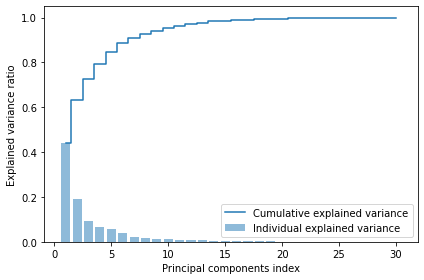

In [2]:
import numpy as np
import matplotlib.pyplot as plt

cov_mat = np.cov(X_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in  sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1,31), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,31), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [5]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

In [16]:
X_pca = X_std.dot(w)

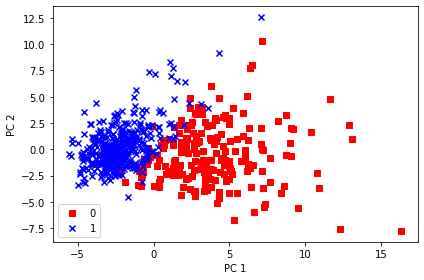

In [20]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X_pca[y==l, 0], X_pca[y==l, 1], c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier):
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cuan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.3)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8,
                    label=cl, 
                    cmap=cmap,
                    edgecolor='black')

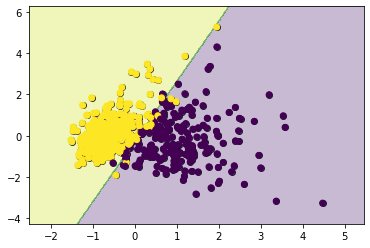

In [8]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2, whiten=True) # whiten 白色化

lr = LogisticRegression(solver='lbfgs')

X_pca = pca.fit_transform(X_std)

lr.fit(X_pca, y)

plot_decision_regions(X_pca, y, lr)
plt.scatter(X_pca[:,0], X_pca[:,1], c=cancer.target)

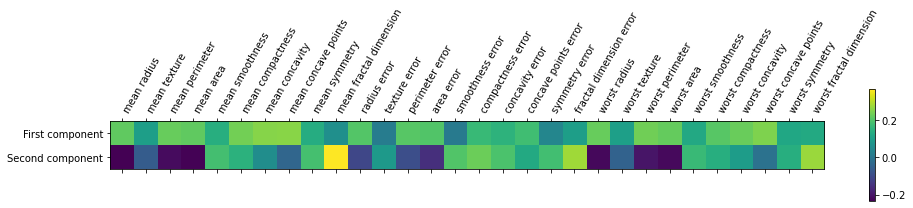

In [9]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
           cancer.feature_names, rotation=60, ha='left');

主成分の重要度を確認する。  
2つの主成分で全体の分散のおよそ63%の分散を捉えている。

In [11]:
pca.explained_variance_ratio_

array([0.44272026, 0.18971182])

#### インクリメンタルPCA
メモリに乗り切らないほど大きいデータセットに対しては、メモリに乗り切るような小さいバッチに分けてPCAを実行する。  
このようなバッチを用いるPCAを**インクリメンタルPCA**と呼ぶ。  
結果は通常のPCAとほぼ同じとなる。

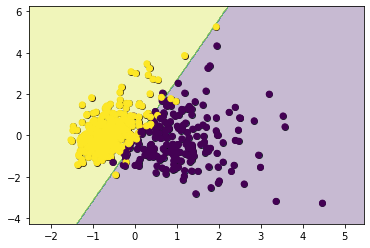

In [15]:
from sklearn.decomposition import IncrementalPCA

inc_pca = IncrementalPCA(n_components=2, whiten=True) # whiten 白色化

lr = LogisticRegression(solver='lbfgs')

X_ipca = inc_pca.fit_transform(X_std)

lr.fit(X_ipca, y)

plot_decision_regions(X_ipca, y, lr)
plt.scatter(X_ipca[:,0], X_ipca[:,1], c=cancer.target)

#### スパースPCA
**スパースPCA**は、入力変数の一部の線形結合で主成分を構成し、元の特徴量空間の次元数をある程度削減する。  
ただし、通常のPCAほど削減しようとはしない。

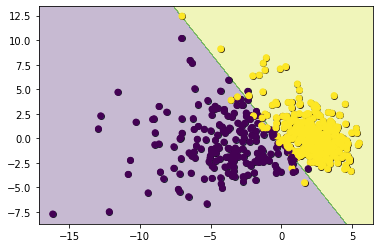

In [19]:
from sklearn.decomposition import SparsePCA

sp_pca = SparsePCA(n_components=2, alpha=0.001)

lr = LogisticRegression(solver='lbfgs')

X_spca = sp_pca.fit_transform(X_std)

lr.fit(X_spca, y)

plot_decision_regions(X_spca, y, lr)
plt.scatter(X_spca[:,0], X_spca[:,1], c=cancer.target)

#### カーネル主成分分析  
線形分離できないデータを変換し、線形分類器に適した新しい低次元の部分空間へ写像する方法である。  
ここではRBFカーネルPCAの実装を見ていく。  
1. カーネル(類似度)行列$\boldsymbol{K}$を計算し、そこで次の計算を行う必要がある。
$$
K(\boldsymbol{x}^{(i)}, \boldsymbol{x}^{(j)})=\exp{(-\gamma|\boldsymbol{x}^{(i)}-\boldsymbol{x}^{(j)}|^2)}
$$

　この計算をデータ点ごとに行い、行列とする。   
2. 以下の式を使ってカーネル行列$\boldsymbol{K}$の中心化を行う。  
$$
\boldsymbol{K'}=\boldsymbol{K}-1_n\boldsymbol{K}-\boldsymbol{K}1_n+1_n\boldsymbol{K}1_n
$$  
　ここで$1_n$はすべての値が$\frac{1}{n}$に等しい$n×n$次元の行列である  
3. 対応する固有値に基づき、中心化されたカーネル行列の$k$個の固有ベクトルを収集する  
　この場合、固有値は大きい順にランク付けされる  
　固有ベクトルは主成分軸ではなく、それらの軸に射影されているデータ点である

In [82]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh

def rbf_kernel_pca(X, gamma, n_components):
    sq_dists = pdist(X, 'sqeuclidean')
    
    mat_sq_dists = squareform(sq_dists)
    
    K = np.exp(-gamma * mat_sq_dists)
    
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:,::-1]
    
    alphas = np.column_stack([eigvecs[:,i] for i in range(n_components)])
    
    lambdas = [eigvals[i] for i in range(n_components)]
    
    return alphas, lambdas

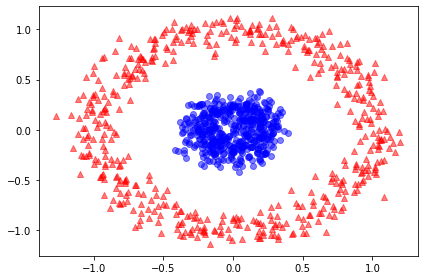

In [92]:
from sklearn.datasets import make_circles, make_moons

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

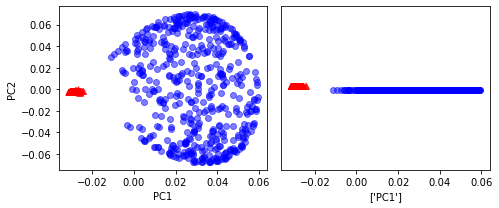

In [84]:
X_kpca, lambdas  = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_yticks([])
ax[1].set_xlabel(['PC1'])
plt.tight_layout()
plt.show()

In [85]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

In [93]:
X, y = make_moons(n_samples=100, random_state=123)
X_kpca, lambdas  = rbf_kernel_pca(X, gamma=15, n_components=1)

x_new = X[25]
x_proj = X_kpca[25]
x_reproj = project_x(x_new, X, gamma=15, alphas=X_kpca, lambdas=lambdas)

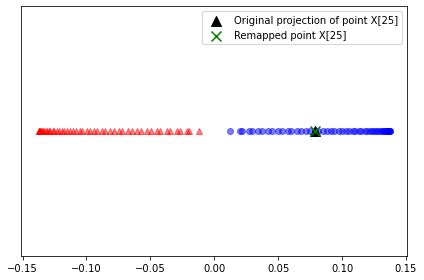

In [96]:
plt.scatter(X_kpca[y==0, 0], np.zeros((50)), color='red', marker='^', alpha=0.5)
plt.scatter(X_kpca[y==1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black', label='Original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green', label='Remapped point X[25]', marker='x', s=100)
plt.yticks([], [])
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()

In [97]:
from sklearn.decomposition import PCA, KernelPCA

X, y = make_circles(n_samples=1000, noise=0.1, factor=0.2)

kpca = KernelPCA(kernel="rbf", gamma=15, n_components=2)
X_kpca = kpca.fit_transform(X)

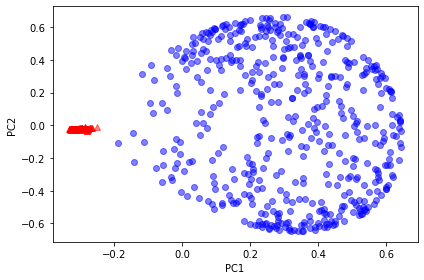

In [98]:
plt.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

#### 線形判別分析（LDA
LDAはクラスの分離を最適化する特徴量部分空間を見つけ出そうとする。  
PCAは教師なしのアルゴリズムであったが、LDAは教師ありのアルゴリズムである。  
LDAでは、データが正規分布に従っていることが前提となる。  
また、クラスの共分散行列がまったく同じであること、訓練データが統計学的に見て互いに独立していることも前提となる。  
ただし、これらの前提を満たしていなくてもそれなりにうまくいく。  
1. $d$次元のデータセットを標準化する($d$は特徴量の個数)
2. クラスごとに$d$次元の平均ベクトル(各次元の平均値で構成されるベクトル)を計算する
3. 平均ベクトルを使って、クラス間変動行列$\boldsymbol{S}_B$と、クラス内変動行列$\boldsymbol{S}_W$を生成する
4. 行列$\boldsymbol{S}_W^{-1}\boldsymbol{S}_B$の固有ベクトルと対応する固有値を計算する
5. 固有値を降順でソートすることで、対応する固有ベクトルをランク付けする
6. $d×k$行列の変換行列$\boldsymbol{W}$を生成するために、最も大きい$k$個の固有値に対応する$k$個の固有ベクトルを生成する
7. 変換行列$\boldsymbol{W}$を使ってデータ点を新しい特徴量部分空間へ射影する
  
各平均ベクトル$\boldsymbol{m}_i$は、クラス$i$のデータ点に関する平均特徴量の値$\mu_m$を格納する
$$
\boldsymbol{m}_i=\frac{1}{n_i}\sum_{\boldsymbol{x}\in D_i}\boldsymbol{x}
$$

In [99]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data
y = iris.target

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [104]:
mean_vecs = []
for label in range(0,3):
    mean_vecs.append(np.mean(X_std[y==label], axis=0))

クラス内変動行列$\boldsymbol{S}_W$を計算する方法は次のようになる
$$
\boldsymbol{S}_W=\sum_{i=1}^c\Sigma_i
$$

個々のクラス$i$について変動行列$\boldsymbol{S}_i$をスケーリングしたものを合計することにより計算される。
$$
\Sigma_i=\frac{1}{n_i}\boldsymbol{S}_i=\frac{1}{n_i}\sum_{x\in D_i}(\boldsymbol{x}-\boldsymbol{m}_i)^T(\boldsymbol{x}-\boldsymbol{m}_i)
$$

In [107]:
d = 4
S_W = np.zeros((d,d))
for label, mv in zip(range(0,3), mean_vecs):
    class_scatter = np.cov(X_std[y==label].T)
    S_W += class_scatter
print(S_W)

[[1.16722735 0.77586555 0.34609473 0.1837458 ]
 [0.77586555 1.83433822 0.21683848 0.29734854]
 [0.34609473 0.21683848 0.17947433 0.09576187]
 [0.1837458  0.29734854 0.09576187 0.21770532]]


クラス間変動$\boldsymbol{S}_B$の計算を行う。
$$
\boldsymbol{S}_B=\sum_{i=1}^cn_i(\boldsymbol{m}_i-\boldsymbol{m})^T(\boldsymbol{m}_i-\boldsymbol{m})
$$

In [108]:
mean_overall = np.mean(X_std, axis=0)
d = 4
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_std[y==i, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
S_B

array([[ 92.80585961, -55.65287963, 113.80442453, 113.68762457],
       [-55.65287963,  60.11742706, -74.89110136, -69.48896849],
       [113.80442453, -74.89110136, 141.20575786, 139.73748309],
       [113.68762457, -69.48896849, 139.73748309, 139.33243952]])

行列$\boldsymbol{S}_W^{-1}\boldsymbol{S}_B$の一般化された固有値問題を解く

In [110]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

1577.404530715622
13.984161088530675
8.445735887679564e-14
2.447906247632024e-14


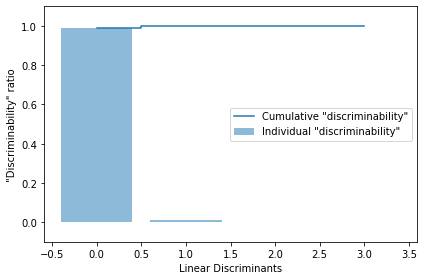

In [113]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(0,4), discr, alpha=0.5, align='center', label='Individual "discriminability"')
plt.step(range(0,4), cum_discr, where='mid', label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

2つの固有ベクトルを列方向に並べて、変換行列$W$を作成する

In [114]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))

データの変換を行う
$$
\boldsymbol{X'}=\boldsymbol{X}\boldsymbol{W}
$$

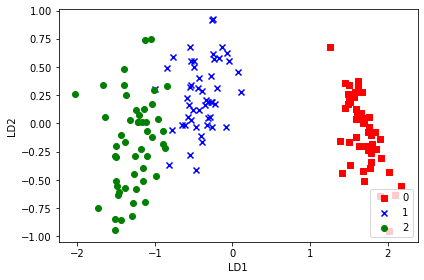

In [117]:
X_lda = X_std.dot(w)
color = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X_lda[y==l, 0], X_lda[y==l, 1]*(-1), c=c, label=l, marker=m)

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [118]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit(X_std, y).transform(X_std)

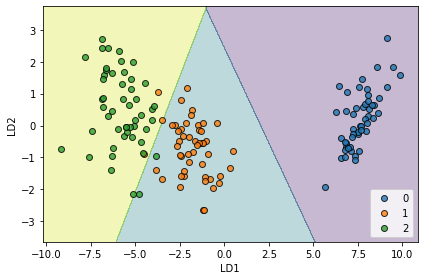

In [119]:
lr = LogisticRegression(multi_class='ovr', solver='lbfgs') 
lr.fit(X_lda, y)

plot_decision_regions(X_lda, y, lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### 非負値行列因子分解(NMF)
NMFは係数と成分が常に0以上(非負)であることが求められる。  
従ってこの方法は個々の特徴量が非負のデータにしか適用できない。  
データを非負の重み付き和に分解する方法は、複数の独立した発生源から得られたデータを重ね合わせて作られるようなデータに有効である。

In [123]:
from sklearn.decomposition import NMF
from sklearn import datasets

nmf = NMF(n_components=2)
X_nmf = nmf.fit_transform(X)

print(X_nmf.shape)

(150, 2)


C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


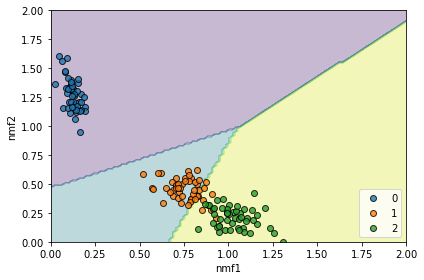

In [132]:
lr = LogisticRegression(multi_class='ovr', solver='lbfgs') 
lr.fit(X_nmf, y)

plot_decision_regions(X_nmf, y, lr)
plt.xlabel('nmf1')
plt.ylabel('nmf2')
plt.xlim(0,2)
plt.ylim(0,2)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### t-SNE(多様体学習アルゴリズム)
可視化によく用いられる**多様体学習アルゴリズム**と呼ばれる一連のアルゴリズムの1つ。  
訓練データの新たな表現を計算するが、新しいデータを変換することはできない。  
従って探索的なデータ解析に有用である。

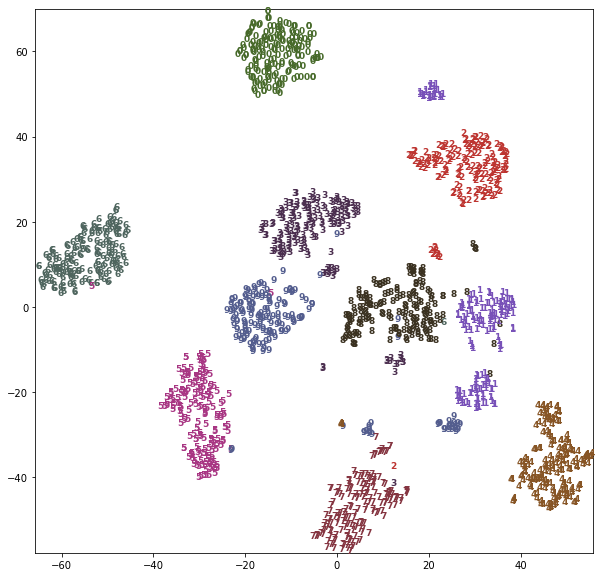

In [140]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

colors = ['#476A2A', '#7851B8', '#BD3430', '#4A2D4E', '#875525',
         '#A83683', '#4E655E', '#853541', '#3A3120', '#535D8E']

digits = load_digits()

tsne = TSNE()
digits_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    plt.text(digits_tsne[i,0], digits_tsne[i,1], str(digits.target[i]),
             color=colors[digits.target[i]], fontdict={'weight': 'bold', 'size': 9})